# ML Classification with PCA and Random Forests

<img src='images/Spiking_traces.PNG' alt='Drawing' style="width: 500px;"/>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("Datasets/intrinsic_cluster_analysis.csv")
data.head(5)

,Unnamed: 0,Delay,Rheobase,Rin,tau,Max,Unnamed: 6
0,1,27.90,75.8,258.000,12.3000,143.0,NaN
1,2,331.90,44.8,412.000,13.4708,66.0,NaN
2,3,134.80,36.0,536.500,23.9807,64.0,NaN
3,4,176.80,26.6,692.000,27.1597,25.0,NaN
4,5,41.42,104.0,318.632,13.0589,30.0,NaN


In [3]:
#Drop NaN and index column, add putative cell type columns

cleaned_data = data.drop(['Unnamed: 0'], axis = 1) #drop unwanted columns
cleaned_data.rename(columns={'Unnamed: 6':'Cell Type'}, inplace=True) #Rename Column with putative cell type
cleaned_data.loc[0:16, 'Cell Type'] = 'Cell Type 1'
cleaned_data.loc[17:45, 'Cell Type'] = 'Cell Type 2'
cleaned_data.loc[46:, 'Cell Type'] = 'Cells to classify'
cleaned_data.rename(columns={'Delay':'Latency to 1st AP (ms)', 'Rheobase':'Rheobase (pA)', 
                             'Rin': 'Input Resistance (MOhms)', 'Max': 'Max Firing (# of APs)', 'tau' : 
                             'Decay Tau (ms)'}, inplace=True)
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Latency to 1st AP (ms)    67 non-null     float64
 1   Rheobase (pA)             67 non-null     float64
 2   Input Resistance (MOhms)  67 non-null     float64
 3   Decay Tau (ms)            67 non-null     float64
 4   Max Firing (# of APs)     67 non-null     float64
 5   Cell Type                 67 non-null     object 
dtypes: float64(5), object(1)
memory usage: 3.3+ KB


In [4]:
def show_boxplot(df):
    plt.rcParams['figure.figsize'] = [14,6] #sets run-time configuration for plot
    sns.boxplot(data = df, orient="v", palette='mako')
    plt.title("Outliers Distribution", fontsize = 16)
    plt.ylabel("Range", fontweight = 'bold')
    plt.xlabel("Attributes", fontweight = 'bold')

Scaled data shape is (67, 5)


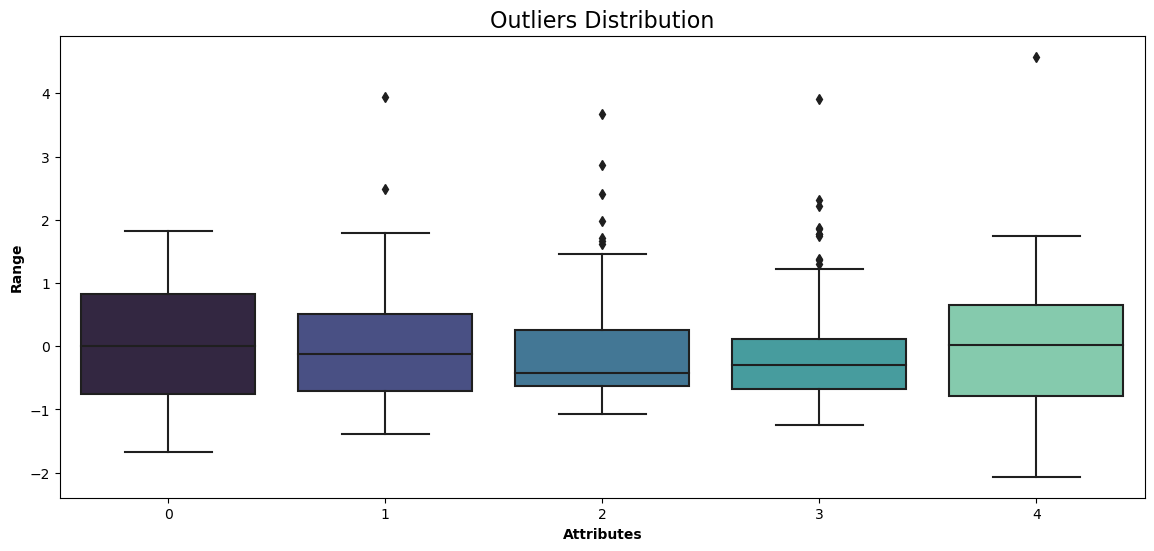

In [5]:
from sklearn.preprocessing import StandardScaler

data_scaler = StandardScaler()

df = pd.DataFrame(cleaned_data.iloc[:,:5]) #dropping column cell type as scaling does not work with object dtype
scaled_data = data_scaler.fit_transform(df)
print ('Scaled data shape is',scaled_data.shape)

show_boxplot(scaled_data)

In [6]:
#Re-append 'cell type' column onto data frame
df_scaled_data = pd.DataFrame(scaled_data)
df_scaled_data['Cell Type'] = cleaned_data['Cell Type']
df_scaled_data.rename(columns={0:'Latency to 1st AP (ms)', 1:'Rheobase (pA)', 2:'Input Resistance (MOhms)', 3:'Decay Tau (ms)', 4:'Max Firing (# of APs)'}, inplace=True) 
df_scaled_data.head()
df_scaled_data.head()

,Latency to 1st AP (ms),Rheobase (pA),Input Resistance (MOhms),Decay Tau (ms),Max Firing (# of APs),Cell Type
0,-1.597525,-0.532602,-0.435153,-0.318385,4.578711,Cell Type 1
1,0.701864,-0.944776,0.312130,-0.156236,1.002232,Cell Type 1
2,-0.788957,-1.061780,0.916265,1.299325,0.909337,Cell Type 1
3,-0.471278,-1.186761,1.670826,1.739598,-0.902127,Cell Type 1
4,-1.495263,-0.157658,-0.140937,-0.213282,-0.669888,Cell Type 1


## Currently data is 5-D, Run PCA to reduce dimensions

### Prepare Data & Taregt

In [7]:
# prepare the data
X = df_scaled_data.iloc[:,0:5]
print(X.shape)

# prepare the target
target = df_scaled_data.iloc[:,5]
target

(67, 5)


0           Cell Type 1
1           Cell Type 1
2           Cell Type 1
3           Cell Type 1
4           Cell Type 1
            ...        
62    Cells to classify
63    Cells to classify
64    Cells to classify
65    Cells to classify
66    Cells to classify
Name: Cell Type, Length: 67, dtype: object

### Run Co-variance Matrix

In [8]:
features = X.T # flip rows and columns
print(f'Features shape is {features.shape}')
print()
print(f'Features are:\n{features[1]}')
# Covariance matrix is the variance of each variable in relation to all others. diagonals are variances with itself, hence is just a measure of variance
# diagonals are identical, so matrix is symmetrical, thanks to the scaling (mean-centering)

cov_matrix = np.cov(features)
print()
print(f'Cov matrix shape is {cov_matrix.shape}')

Features shape is (5, 67)

Features are:
Latency to 1st AP (ms)      0.701864
Rheobase (pA)              -0.944776
Input Resistance (MOhms)    0.312130
Decay Tau (ms)             -0.156236
Max Firing (# of APs)       1.002232
Name: 1, dtype: float64

Cov matrix shape is (5, 5)


<Axes: >

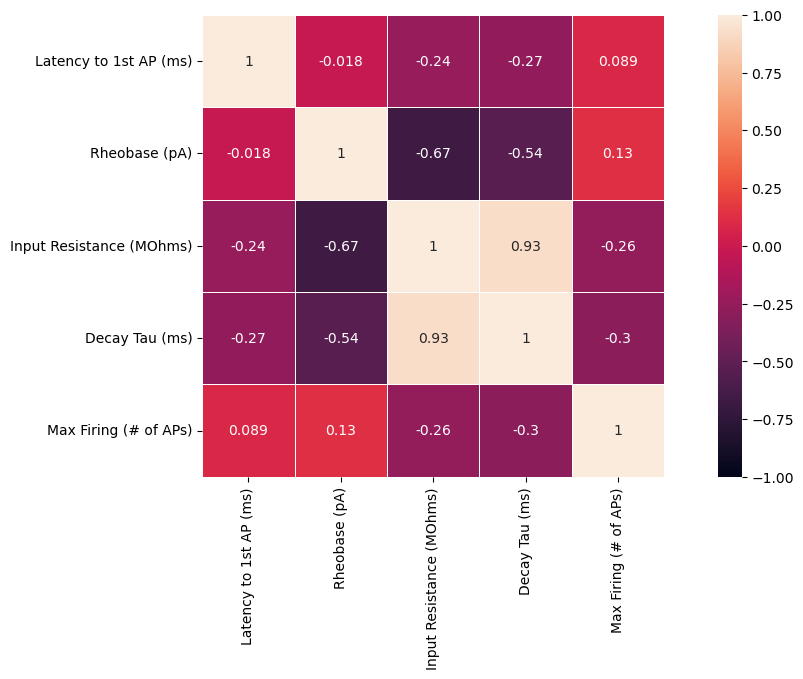

In [9]:
tick_labels = cleaned_data.columns[:5].tolist() #casting column names to list for easy labelling

sns.heatmap(cov_matrix, 
            xticklabels = tick_labels, 
            yticklabels = tick_labels, 
            linewidth=.5, 
            vmin = -1.0, 
            vmax = 1.0,
            annot=True,
            square=True
           )

### At this stage I could drop values that have a high co-variance.
However, as this is already known (i.e. these are co-dependent biophysical properties), I am not going to drop any variables.

### Run Eigen-decomposition & Data Transformation

In [10]:
eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)
print(f'The eigen values are \n{eigen_values}')
print(f'The eigen vectors are \n{eigen_vectors}')

The eigen values are 
[2.6196065  1.04111819 0.90869641 0.43550276 0.07083371]
The eigen vectors are 
[[-0.1962199   0.84997514  0.35034001  0.34081103 -0.01223679]
 [-0.45801736 -0.45328465  0.12043448  0.73708445 -0.16418029]
 [ 0.59542848  0.06779803 -0.11376062  0.26384058 -0.74720481]
 [ 0.57730322 -0.02754604 -0.07052344  0.49668378  0.64365664]
 [-0.25279194  0.25830201 -0.91915308  0.15571683  0.0169173 ]]


In [11]:
n_components = 2 #select the first n eigenvectors, n is desired dimension of our final reduced data.
eigenvector_subset = eigen_vectors[:, 0:n_components]
eigenvector_subset

array([[-0.1962199 ,  0.84997514],
       [-0.45801736, -0.45328465],
       [ 0.59542848,  0.06779803],
       [ 0.57730322, -0.02754604],
       [-0.25279194,  0.25830201]])

In [12]:
print("Subset shape", eigenvector_subset.shape, eigenvector_subset.transpose().shape)
print("Scaled shape", X.shape, X.transpose().shape)

X_reduced = np.dot(eigenvector_subset.transpose(), X.transpose()).transpose()
print("Transformed shape untransposed", np.dot(eigenvector_subset.transpose(), X.transpose()).shape)
print("Transformed shape", X_reduced.shape)
print("Transformed sample", X_reduced[:10])

Subset shape (5, 2) (2, 5)
Scaled shape (67, 5) (5, 67)
Transformed shape untransposed (2, 67)
Transformed shape (67, 2)
Transformed sample [[-1.04296096  0.04552177]
 [ 0.13730334  1.30916358]
 [ 1.70692414  0.07190773]
 [ 2.86321497 -0.03029556]
 [ 0.3279065  -1.37618608]
 [ 1.86399183 -0.98225805]
 [ 2.77396582 -0.18428092]
 [ 2.90228611 -0.9483066 ]
 [ 3.24659359  0.137223  ]
 [ 2.95947637 -0.31202469]]


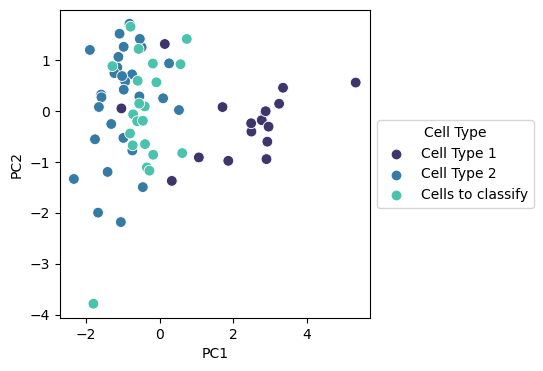

In [13]:
pca_df = pd.DataFrame(X_reduced, columns = ['PC1','PC2']) # Creating a Pandas DataFrame of reduced Dataset
 
# Concat it with target variable to create a complete Dataset
pca_df = pd.concat([pca_df, pd.DataFrame(target)], axis=1)

plt.figure(figsize=(4,4))
g= sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cell Type', s=60, palette='mako')
sns.move_legend(g,'center left', bbox_to_anchor=(1,0.5))

In [14]:
explained_variances = []
for i in range(len(eigen_values)):
    explained_variances.append(eigen_values[i] / np.sum(eigen_values))
 
print(np.sum(explained_variances))
print(explained_variances)

1.0
[0.5161015785932799, 0.20511582327043107, 0.1790267556168585, 0.08580054359749098, 0.013955298921939549]


#### Running a Random Forest Classifier with the decomposed dataset

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

In [16]:
df_scaled_data_train = df_scaled_data.iloc[:46,:] #use only subset of data that we have ground truth for, once a model is picked then use it to predict the 'cells to classify'

X = df_scaled_data_train.drop('Cell Type', axis=1)
y = df_scaled_data_train['Cell Type']

#first run the calssifier without PCA
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, max_depth=3)

clf.fit(X_train, y_train)

print("Accuracy on training set {}".format(clf.score(X_train, y_train)))

y_pred = clf.predict(X_test)

print('Accuracy on test set{}'.format(accuracy_score(y_test, y_pred)))

Accuracy on training set 1.0
Accuracy on test set0.9166666666666666


In [17]:
#with PCA with 2 components

X = df_scaled_data_train.drop('Cell Type', axis=1)
y = df_scaled_data_train['Cell Type']

pca = PCA(n_components = 2).fit(X)
pca_X = pca.transform(X)

X_train, X_test, y_train, y_test = train_test_split(pca_X, y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, max_depth=3)

clf.fit(X_train, y_train)

print("Accuracy on training set {}".format(clf.score(X_train, y_train)))

y_pred = clf.predict(X_test)

print("Accuracy on test set {}".format(accuracy_score(y_test, y_pred))) #while training accuracy is lower, test accuracy remains the same.

Accuracy on training set 0.9705882352941176
Accuracy on test set 0.9166666666666666


In [18]:
print (f'The PCA explained variance is: {pca.explained_variance_} \n While the variance ratio is {pca.explained_variance_ratio_}')

The PCA explained variance is: [3.59254161 1.09649258] 
 While the variance ratio is [0.62623805 0.19113637]


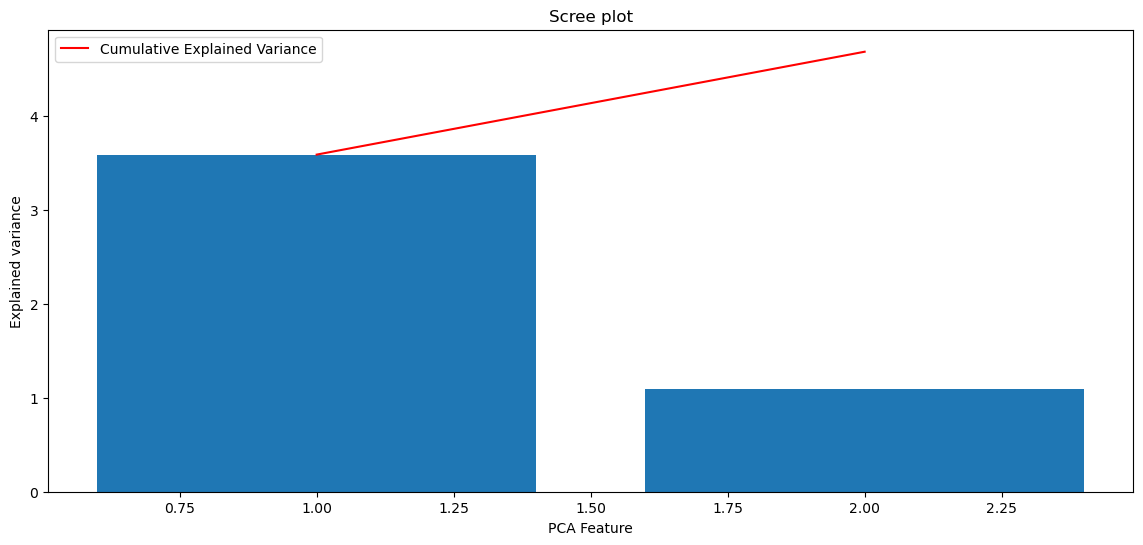

In [19]:
# Bar plot of explained_variance
plt.bar(range(1,len(pca.explained_variance_)+1), pca.explained_variance_)
plt.plot(range(1,len(pca.explained_variance_ )+1),  np.cumsum(pca.explained_variance_), c='red', label='Cumulative Explained Variance')
plt.legend(loc='upper left')
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Scree plot')
plt.show()

### We will now use the reduced df to predict the values of the 'Cell type' of the 'Cells to classify'

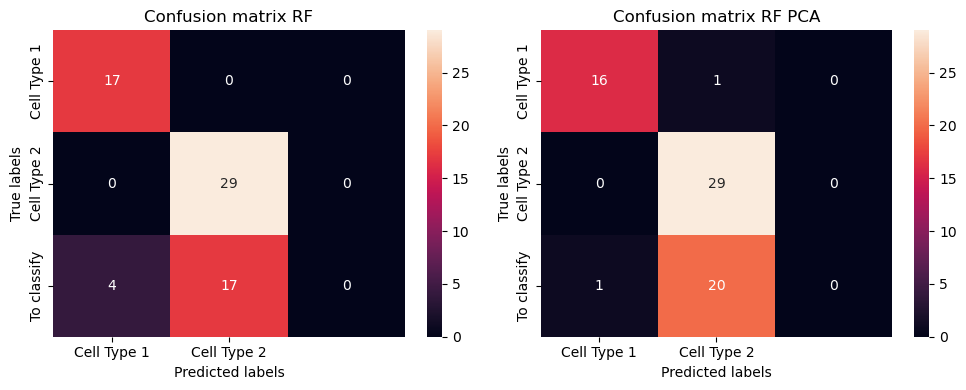

In [25]:
from sklearn.metrics import confusion_matrix

X = df_scaled_data_train.drop('Cell Type', axis=1)
y = df_scaled_data_train['Cell Type']

pca = PCA(n_components = 2).fit(X)
pca_X = pca.transform(X)

X_test = df_scaled_data.drop('Cell Type', axis=1)
y_test = df_scaled_data['Cell Type']
pca_X_test = pca.transform(X_test)

clf = RandomForestClassifier(n_estimators=100, max_depth=3)

clf.fit(X, y)
pred_data = clf.predict(X_test)
cm_RF = confusion_matrix(y_test, clf.predict(X_test))

clf.fit(pca_X, y)
pred_data_pca = clf.predict(pca_X_test)
cm_RF_PCA = confusion_matrix(y_test, clf.predict(pca_X_test))

fig, axs = plt.subplots(1, 2, figsize=(10,4))

sns.heatmap(cm_RF, xticklabels=['Cell Type 1', 'Cell Type 2'], yticklabels=['Cell Type 1', 'Cell Type 2', 'To classify'], annot=True, fmt='d', ax=axs[0])
axs[0].set_title("Confusion matrix RF")
sns.heatmap(cm_RF_PCA, xticklabels=['Cell Type 1', 'Cell Type 2'], yticklabels=['Cell Type 1', 'Cell Type 2', 'To classify'], annot=True, fmt='d', ax=axs[1])
axs[1].set_title("Confusion matrix RF PCA")

for ax in axs.flat:
        ax.set(xlabel='Predicted labels', ylabel='True labels')
        ax.label_outer()
plt.tight_layout()
plt.show()

In [21]:
cleaned_data = pd.concat ([cleaned_data, pd.DataFrame(pred_data, columns =['RF_Cell Type'])], axis=1) #append column onto main dataframe
cleaned_data = pd.concat ([cleaned_data, pd.DataFrame(pred_data_pca, columns =['RF_Cell Type_PCA'])], axis=1) #append column onto main dataframe

cleaned_data.tail()

,Latency to 1st AP (ms),Rheobase (pA),Input Resistance (MOhms),Decay Tau (ms),Max Firing (# of APs),Cell Type,RF_Cell Type,RF_Cell Type_PCA
62,332.633343,90.67,192.53,5.62,56.0,Cells to classify,Cell Type 2,Cell Type 2
63,193.566657,146.67,270.96,11.89,31.0,Cells to classify,Cell Type 2,Cell Type 2
64,48.466670,92.67,231.92,9.09,38.4,Cells to classify,Cell Type 2,Cell Type 2
65,21.166670,412.67,127.94,12.01,0.0,Cells to classify,Cell Type 2,Cell Type 2
66,198.900000,80.00,217.55,8.43,33.2,Cells to classify,Cell Type 2,Cell Type 2


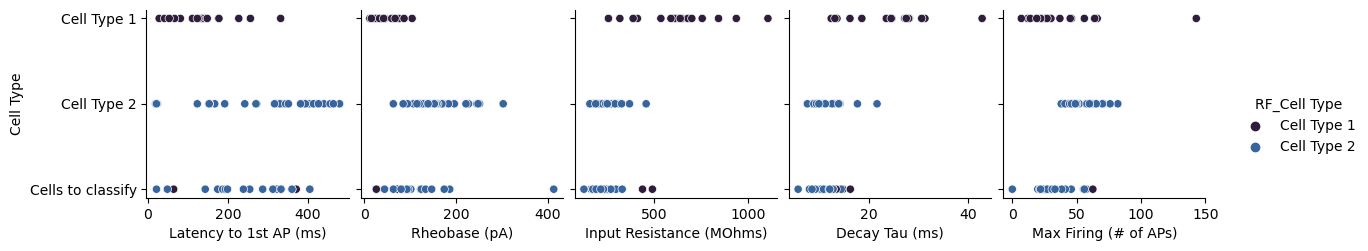

In [22]:
sns.pairplot(
    cleaned_data, 
    x_vars=['Latency to 1st AP (ms)', 'Rheobase (pA)', 'Input Resistance (MOhms)', 'Decay Tau (ms)', 'Max Firing (# of APs)'],
    y_vars=['Cell Type'],
    hue='RF_Cell Type', 
    palette= {'Cell Type 1':'#2e1e3b', 'Cell Type 2':'#37659e'},
)
plt.show()

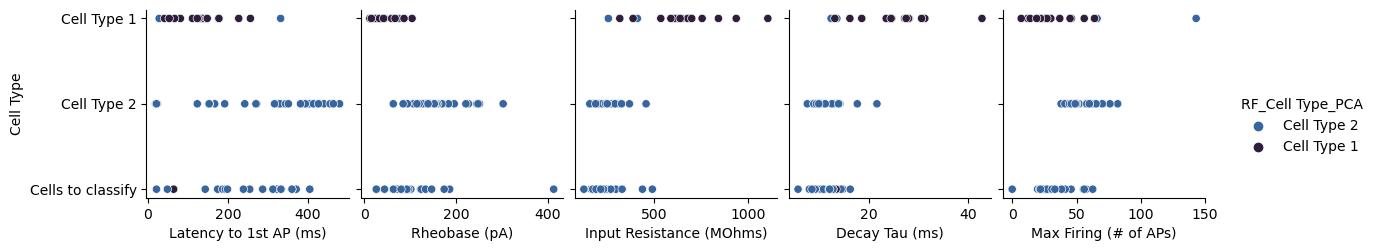

In [23]:
sns.pairplot(
    cleaned_data, 
    x_vars=['Latency to 1st AP (ms)', 'Rheobase (pA)', 'Input Resistance (MOhms)', 'Decay Tau (ms)', 'Max Firing (# of APs)'],
    y_vars=['Cell Type'],
    hue='RF_Cell Type_PCA', 
    palette= {'Cell Type 1':'#2e1e3b', 'Cell Type 2':'#37659e'},
)
plt.show()